## Installing prerequisities:

In [1]:
!pip install numpy pandas torch torchvision matplotlib mplcyberpunk

## Importing necessary libraries:

In [2]:
import torch
import torchvision
from torch import nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import TensorDataset as Dataset
from torchvision import models
from torchvision import transforms
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import gc
import mplcyberpunk
plt.style.use('cyberpunk')

## Preparing and loading the data:

In [3]:
!sudo apt install unzip
!unzip ./shoes.zip -d .

In [4]:
def create_dataframe(base_dir, categories):

    data = []

    for category in categories:
        category_path = os.path.join(base_dir, category)

        for filename in os.listdir(category_path):
            if filename.lower().endswith(('.jpg')):
                image_path = os.path.join(category_path, filename)
                image = torch.from_numpy(plt.imread(image_path))
                data.append((image, category))

    return pd.DataFrame(data, columns=['image', 'label'])

In [5]:
train_dir = "train"
test_dir = "test"
categories = ['adidas', 'converse', 'nike']

train_df = create_dataframe(train_dir, categories).sample(frac = 1)
test_df = create_dataframe(test_dir, categories).sample(frac = 1)
train_df

/tmp/ipykernel_2455870/1239560398.py:11: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  image = torch.from_numpy(plt.imread(image_path))


,image,label
206,"[[[tensor(254, dtype=torch.uint8), tensor(254,...",adidas
5,"[[[tensor(255, dtype=torch.uint8), tensor(255,...",adidas
539,"[[[tensor(58, dtype=torch.uint8), tensor(91, d...",nike
643,"[[[tensor(246, dtype=torch.uint8), tensor(246,...",nike
282,"[[[tensor(255, dtype=torch.uint8), tensor(255,...",converse
...,...,...
648,"[[[tensor(246, dtype=torch.uint8), tensor(246,...",nike
384,"[[[tensor(255, dtype=torch.uint8), tensor(255,...",converse
2,"[[[tensor(69, dtype=torch.uint8), tensor(69, d...",adidas
528,"[[[tensor(227, dtype=torch.uint8), tensor(227,...",nike


## Visualizing a sample from the data:

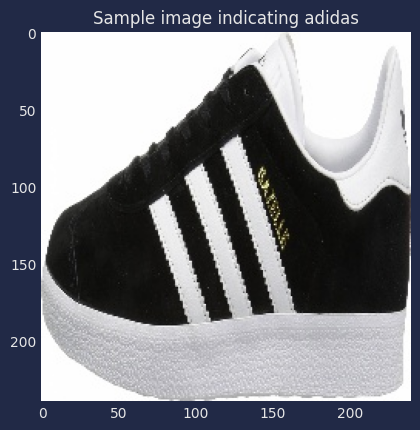

In [6]:
index = 0
image = train_df["image"].iloc[index]
label = train_df["label"].iloc[index]
plt.title(f"Sample image indicating {label}")
plt.grid(False)
plt.imshow(image)
plt.show()

## Changing the format of labels and extracting the data:

In [7]:
y_train = train_df['label'].map({"adidas": 0, "converse": 1, "nike": 2}).values
y_test = test_df['label'].map({"adidas": 0, "converse": 1, "nike": 2}).values
x_train = train_df["image"].values
x_test = test_df["image"].values

In [8]:
y_test = torch.nn.functional.one_hot(torch.from_numpy(y_test).type(torch.LongTensor), num_classes=3)
y_train = torch.nn.functional.one_hot(torch.from_numpy(y_train).type(torch.LongTensor), num_classes=3)
y_train = y_train.type(torch.float).requires_grad_()
y_test = y_test.type(torch.float).requires_grad_()

## Extracting 100 samples for validation set:

In [9]:
y_CV = y_train[:100]
x_CV = x_train[:100]
x_train = x_train[100:]
y_train = y_train[100:]

# Basic model:
- two layers in the hidden layer of the head
- using ResNet50 as base
- freezing all the layers of ResNet50 for using the pretrained mode on ImageNet

In [10]:
model = models.resnet50(weights=True)

for param in model.parameters():
    param.requires_grad = False
num_features = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.25),
    nn.Linear(256, 3)
)
print(model)

/home/ubuntu/compex/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
criterion = CrossEntropyLoss()
optimizer = Adam(params=model.parameters(), lr=0.003)

## Defining dataloaders for efficiently loading the batches during training:

In [12]:
x_train_loader = torch.utils.data.DataLoader(dataset=x_train,
                                              batch_size=8,
                                              shuffle=False)
y_train_loader = torch.utils.data.DataLoader(dataset=y_train,
                                              batch_size=8,
                                              shuffle=False)
x_cv_loader = torch.utils.data.DataLoader(dataset=x_CV,
                                            batch_size=100,
                                            shuffle=False)
x_test_loader = torch.utils.data.DataLoader(dataset=x_test,
                                            batch_size=114,
                                            shuffle=False)

In [13]:
def accuracy(predicted, actual):

    train_correct = torch.eq(predicted.argmax(dim=-1),actual.argmax(dim=-1)).sum().item()
    return (train_correct / len(actual)) * 100

# Training loop with storing the history:

In [14]:
tic, toc = time.time(), time.time()
epochs, train_accuracy_list, train_loss_list, CV_accuracy_list = [], [], [], []
model.cuda()

for epoch in range(15):

    model.train()
    mean_acc = 0
    mean_loss = 0

    for x_temp, y_temp in zip(x_train_loader, y_train_loader):

        x_temp = x_temp.type(torch.float32).requires_grad_().cuda()
        y_temp = y_temp.cuda()
        y_pred = model(x_temp.permute(0,3,1,2))

        acc = accuracy(y_pred,y_temp)
        mean_acc += acc
        train_accuracy_list.append(acc)

        loss = criterion(y_pred,y_temp)
        mean_loss += loss
        train_loss_list.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        del x_temp
        del y_temp
        gc.collect()

    epochs.append(epoch)

    with torch.inference_mode():
        for x_cv in x_cv_loader:
            x_cv = x_cv.type(torch.float32).cuda()
            y_cv_pred = model(x_cv.permute(0,3,1,2)).cpu()
            acc_cv = accuracy(y_cv_pred,y_CV)
            CV_accuracy_list.append(acc_cv)
            del y_cv_pred
            del x_cv
            gc.collect()

    mean_acc /= 77
    mean_loss /= 77
    gc.collect()

    toc = time.time()

    print(f'epoch {epoch+1} | loss: {mean_loss:.3f} | train accuracy: % {mean_acc:.4f} | val accuracy: % {acc_cv:.3f} ',
          f'| spent time: {toc-tic:.2f} sec')

    tic = time.time()

epoch 1 | loss: 1.157 | train accuracy: % 36.5260 | val accuracy: % 58.000  | spent time: 16.27 sec
epoch 2 | loss: 1.026 | train accuracy: % 46.1039 | val accuracy: % 47.000  | spent time: 15.17 sec
epoch 3 | loss: 0.903 | train accuracy: % 53.5173 | val accuracy: % 53.000  | spent time: 15.39 sec
epoch 4 | loss: 0.817 | train accuracy: % 60.9848 | val accuracy: % 60.000  | spent time: 16.47 sec
epoch 5 | loss: 0.739 | train accuracy: % 65.7468 | val accuracy: % 72.000  | spent time: 16.49 sec
epoch 6 | loss: 0.725 | train accuracy: % 66.5043 | val accuracy: % 60.000  | spent time: 16.11 sec
epoch 7 | loss: 0.653 | train accuracy: % 70.9957 | val accuracy: % 70.000  | spent time: 15.92 sec
epoch 8 | loss: 0.590 | train accuracy: % 75.2165 | val accuracy: % 69.000  | spent time: 16.23 sec
epoch 9 | loss: 0.574 | train accuracy: % 76.0281 | val accuracy: % 71.000  | spent time: 17.14 sec
epoch 10 | loss: 0.558 | train accuracy: % 75.9199 | val accuracy: % 69.000  | spent time: 15.98 sec

# Evaluating the model on the test set:

In [15]:
with torch.inference_mode():
    for x_test in x_test_loader:
        x_test = x_test.type(torch.float32).cuda()
        y_test_pred = model(x_test.permute(0,3,1,2)).cpu()
        acc_test = accuracy(y_test_pred, y_test)

print(f"\n\nAccuracy for the test set: {acc_test}\n\n")



Accuracy for the test set: 65.78947368421053




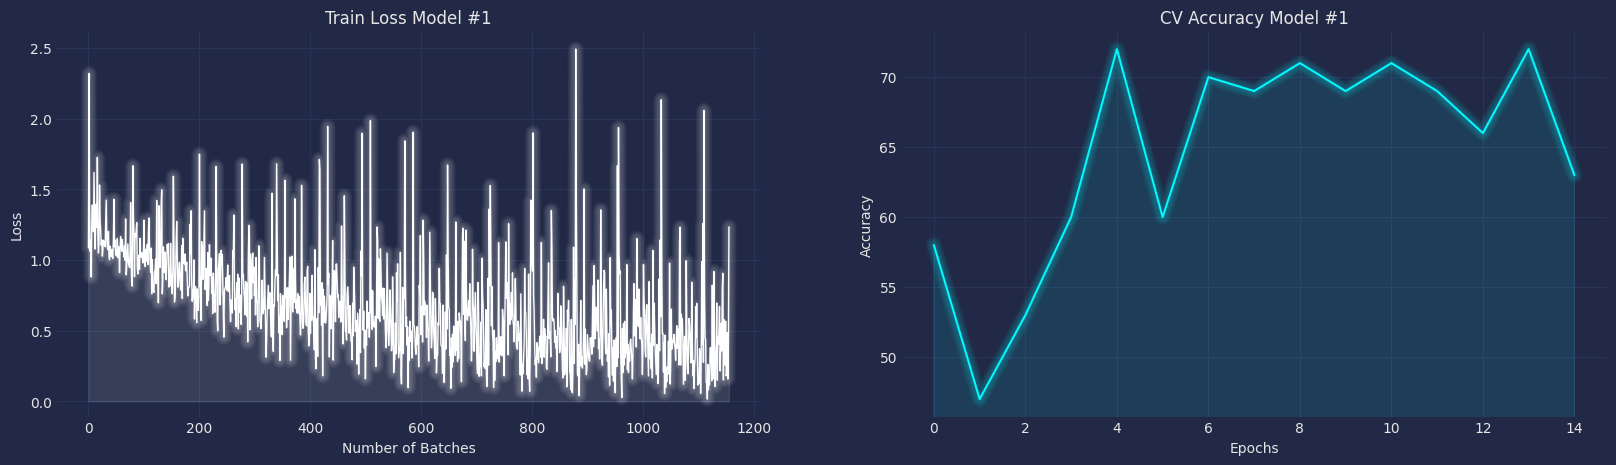

In [16]:
plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.plot([y.cpu().detach().numpy() for y in train_loss_list], linewidth=1, c='white')
plt.title('Train Loss Model #1')
plt.xlabel('Number of Batches')
plt.ylabel('Loss')
mplcyberpunk.make_lines_glow()
mplcyberpunk.add_underglow()

plt.subplot(1, 2, 2)
plt.plot(epochs, CV_accuracy_list)
plt.title('CV Accuracy Model #1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
mplcyberpunk.make_lines_glow()
mplcyberpunk.add_underglow()
plt.show()

# New model:
- freezing only a part of resnet for more dynamicity and more adaptation to the task
- training the last layer of ResNet50 (which includes multiple convolutional layers)
- using BatchNorm for stabilizing the learning

In [22]:
model2 = models.resnet50(weights=True)

for name, param in model2.named_parameters():
    if "layer4" not in name:
        param.requires_grad = False

num_features = model2.fc.in_features

model2.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.5),
    nn.Linear(256, 3)
)
print(model2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
criterion = CrossEntropyLoss()
optimizer = Adam(params=model2.parameters(), lr=0.005)

In [24]:
tic, toc = time.time(), time.time()
epochs, train_accuracy_list, train_loss_list, CV_accuracy_list = [], [], [], []
model2.cuda()

for epoch in range(10):

    model2.train()
    mean_acc = 0
    mean_loss = 0

    for x_temp, y_temp in zip(x_train_loader, y_train_loader):

        x_temp = x_temp.type(torch.float32).requires_grad_().cuda()
        y_temp = y_temp.cuda()
        y_pred = model2(x_temp.permute(0,3,1,2))

        acc = accuracy(y_pred,y_temp)
        mean_acc += acc
        train_accuracy_list.append(acc)

        loss = criterion(y_pred,y_temp)
        mean_loss += loss
        train_loss_list.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        del x_temp
        del y_temp
        gc.collect()

    epochs.append(epoch)

    with torch.inference_mode():
        for x_cv in x_cv_loader:
            x_cv = x_cv.type(torch.float32).cuda()
            y_cv_pred = model2(x_cv.permute(0,3,1,2)).cpu()
            acc_cv = accuracy(y_cv_pred,y_CV)
            CV_accuracy_list.append(acc_cv)
            del y_cv_pred
            del x_cv
            gc.collect()

    mean_acc /= 77
    mean_loss /= 77
    gc.collect()

    toc = time.time()

    print(f'epoch {epoch+1} | loss: {mean_loss:.3f} | train accuracy: % {mean_acc:.4f} | val accuracy: % {acc_cv:.3f} ',
          f'| spent time: {toc-tic:.2f} sec')

    tic = time.time()

epoch 1 | loss: 1.121 | train accuracy: % 40.6926 | val accuracy: % 54.000  | spent time: 14.77 sec
epoch 2 | loss: 0.903 | train accuracy: % 54.4913 | val accuracy: % 58.000  | spent time: 16.28 sec
epoch 3 | loss: 0.815 | train accuracy: % 60.4978 | val accuracy: % 78.000  | spent time: 15.84 sec
epoch 4 | loss: 0.642 | train accuracy: % 75.4329 | val accuracy: % 83.000  | spent time: 15.45 sec
epoch 5 | loss: 0.484 | train accuracy: % 83.6039 | val accuracy: % 89.000  | spent time: 15.09 sec
epoch 6 | loss: 0.407 | train accuracy: % 88.2035 | val accuracy: % 83.000  | spent time: 14.98 sec
epoch 7 | loss: 0.366 | train accuracy: % 89.6645 | val accuracy: % 85.000  | spent time: 15.93 sec
epoch 8 | loss: 0.288 | train accuracy: % 91.9372 | val accuracy: % 89.000  | spent time: 16.23 sec
epoch 9 | loss: 0.285 | train accuracy: % 94.0476 | val accuracy: % 85.000  | spent time: 15.72 sec
epoch 10 | loss: 0.285 | train accuracy: % 92.4242 | val accuracy: % 85.000  | spent time: 16.19 sec

In [27]:
with torch.inference_mode():
    for x_test in x_test_loader:
        x_test = x_test.type(torch.float32).cuda()
        y_test_pred = model2(x_test.permute(0,3,1,2)).cpu()
        acc_test = accuracy(y_test_pred, y_test)

print(f"\n\nAccuracy for the test set: {acc_test}\n\n")



Accuracy for the test set: 87.71929824561403




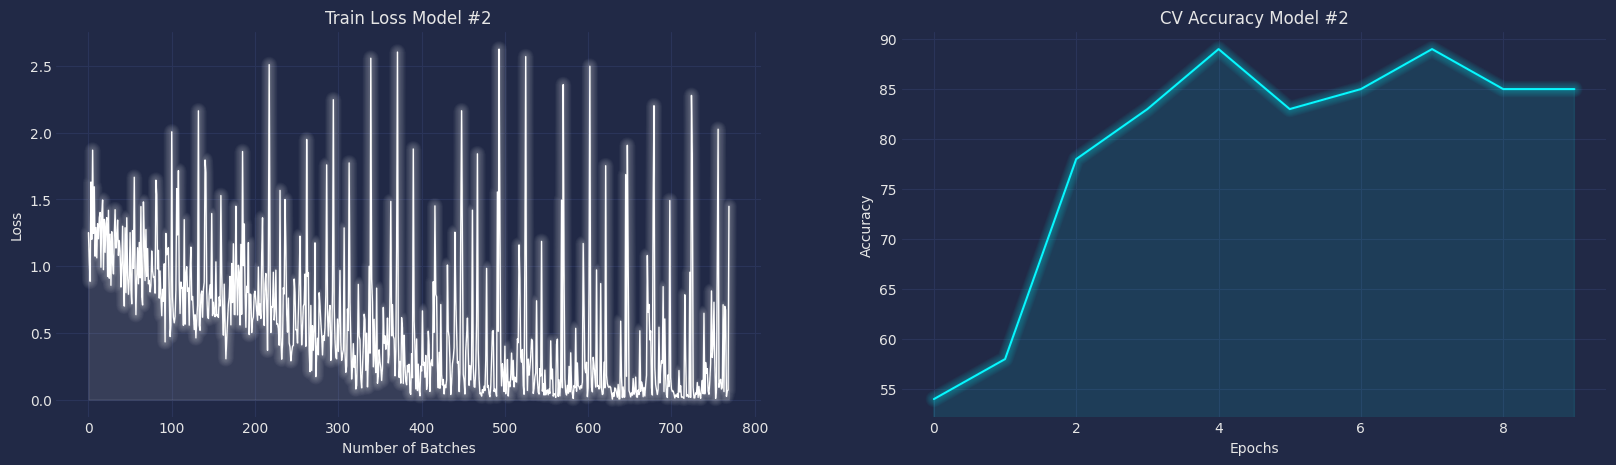

In [28]:
plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.plot([y.cpu().detach().numpy() for y in train_loss_list], linewidth=1, c='white')
plt.title('Train Loss Model #2')
plt.xlabel('Number of Batches')
plt.ylabel('Loss')
mplcyberpunk.make_lines_glow()
mplcyberpunk.add_underglow()

plt.subplot(1, 2, 2)
plt.plot(epochs, CV_accuracy_list)
plt.title('CV Accuracy Model #2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
mplcyberpunk.make_lines_glow()
mplcyberpunk.add_underglow()
plt.show()

## Saving the model:

In [29]:
torch.save(model2, "nike-adidas-converse.pth")